# Notebook to Preprocess MIMIC-III v1.4 Data Files

In this notebook we will preprocess the [MIMIC-III](https://physionet.org/content/mimiciii/1.4/) v1.4 data files as extracted by [MIMIC-Code](https://github.com/MIT-LCP/mimic-code).

The output of this notebook will be a pandas `DataFrame` (stored as a CSV file) with six columns:
- `episode`: An identifier for each ICU admission
- `timestep`: A `DateTime` object specifying the exact time a point measurement was made (e.g. `heart_rate`) or an interval was sampled (e.g. `max_vaso`)
- `x0`\*: An integer identifier specifying the type of measurement recorded at this timestep, e.g., a `heart_rate` measurement (`5`) or a lab result, such as `trombo` levels (`32`).
- `x1`\*: The value of the actual measurement in the appropriate unit (e.g. ml, bmp, mmHg)
- `x2`\*: `timestep` converted to hours relative to the start of treatment phase (set to 24h prior to sepsis onset)
- `reward`: Reward accrued at each decision point (`NaN` for non-decision points)
- `action`: Action taken at each decision point (`NaN` for non-decision points)

\* we use the `x*` notation for this state space to allow us to use the exact same training scripts for Q-learning also for the transformer encoder.

Measurements in the dataset are primarily timestamped point measurements (see EDA), that is *values recorded at specific times*; however, **vasopressor** and **IV fluid intake** are recorded in terms of `(starttime, endtime)` intervals. As these treatments are actions in our **action space**, we sample them every 4 hours much like Roggeveen et al., allowing direct comparison of actions taken at the same points in time.

**Important**: Make sure to run the `MIMIC-III_preprocessing_roggeveen.ipynb` notebook first, as the trainval/test split is made there and reused to create an identical dataset split here.

In [98]:
# Dependencies
import os
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Settings
INTERVAL_TIME = '4h'
USE_CAREVUE = True
DATA_DIR = '../data/mimic-iii/final/'                             # Where dataset is stored
OUTPUT_DIR_ROGGEVEEN = 'datasets/mimic-iii/roggeveen_4h_with_cv'  # We will be reusing the train/valid/test split and action space made previously
OUTPUT_DIR = 'datasets/mimic-iii/attention'                       # Where preprocessed data will be stored

In [99]:
# Check whether previous notbooks have been executed and data is in the right location
if not os.path.exists(OUTPUT_DIR_ROGGEVEEN):
    raise Exception('Cannot find %s. Please run `MIMIC-III_preprocessing_roggeveen.ipynb`.' % OUTPUT_DIR_ROGGEVEEN)

if not os.path.exists(DATA_DIR):
    raise Exception('Dataset directory %s does not exist!' % DATA_DIR)

# Create output_dir if not yet created
OUTPUT_DIR = OUTPUT_DIR + '_%s%s/' % (INTERVAL_TIME, '_with_cv' if USE_CAREVUE else '')
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
print('Good to go!')

Good to go!


### Convenience functions

We define some convenience funxtions which we can reuse throughout the notebook (e.g. for data loading, plotting, unit conversions, etc.)

In [4]:
# Read CSV from file and parse dates using pd.to_datetime()
def read_csv(fname):
    df = pd.read_csv(fname)
    
    # Explicit as parse_dates param of pd.read_csv fails to identify starttime and endtime
    parse_dates = ['intime', 'outtime', 'starttime', 'endtime', 'window_start', 
                   'window_end', 'charttime', 'suspected_infection_time_poe']
    
    for col in parse_dates:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])
    return df

# Plots values of under `key` over time
def plot_single(df, item_id, title='', xlabel='Timestep', ylabel='Value', style='.-'):
    # Randomly choose icustay_id with data for item_id
    icustay_id = None
    while icustay_id is None:
        icustay_id = random.choice(list(set(df['episode'])))
        num_values = (df[(df['x0'] == item_id) & (df['episode'] == icustay_id)]['x1'] != 0).sum()
        icustay_id = None if num_values == 0 else icustay_id
        
    # Limit to item_id and chosen icustay_id
    df = df[(df['x0'] == item_id) & (df['episode'] == icustay_id)]
        
    plt.figure(figsize=(8, 3))
    plt.plot(df['timestep'], df['x1'], style)
    plt.title('%s (icustay_id=%d)' % (title, icustay_id))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Converts TimeDelta objects into hours
def to_hours(x):
    # pd.Timedelta does not have astype method
    if isinstance(x, pd.Timedelta):
        return x.total_seconds() / 3600
    return x.astype('timedelta64[s]').astype(int) / 3600

# Converts upper- or camelcase to snake-case (lowercase with '_' separators)
def to_snakecase(string):
    if string.islower():
        return string
    elif string.isupper():
        return string.lower()
    else:
        string = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', string)
        return re.sub('([a-z0-9])([A-Z])', r'\1_\2', string).lower()
    
print('HeartRate => %s' % to_snakecase('HeartRate'))
print('ALBUMIN   => %s' % to_snakecase('ALBUMIN'))
print('MeanBP    => %s' % to_snakecase('MeanBP'))

HeartRate => heart_rate
ALBUMIN   => albumin
MeanBP    => mean_bp


---
## Patient Cohort

Using MIMIC-Code we have extracted a *sepsis-3* cohort (i.e. a list of patients satisfying the sepsis-3 criteria (Singer et al., 2016)) along with information regarding the suspected time of infection and in-hospital mortality, `hospital_expire_flag`. Let's first import these data;

In [5]:
cohort_df = read_csv(DATA_DIR + 'cohort.csv')

print('Number of admissions: %s\n' % len(cohort_df))
cohort_df.head()

Number of admissions: 18346



,subject_id,hadm_id,icustay_id,intime,outtime,suspected_infection_time_poe,window_start,window_end,hospital_expire_flag
0,55597,189080,226090,2122-04-13 22:38:32,2122-04-14 18:26:03,2122-04-13 21:35:00,2122-04-12 21:35:00,2122-04-15 21:35:00,0
1,6645,177907,205861,2105-07-11 21:28:35,2105-07-13 17:13:43,2105-07-11 00:00:00,2105-07-10 00:00:00,2105-07-13 00:00:00,0
2,30496,165002,281987,2194-06-18 14:03:07,2194-06-19 21:35:23,2194-06-18 00:00:00,2194-06-17 00:00:00,2194-06-20 00:00:00,0
3,92531,184997,218267,2171-07-10 15:10:29,2171-07-11 14:20:11,2171-07-10 11:40:00,2171-07-09 11:40:00,2171-07-12 11:40:00,0
4,28677,159991,282170,2122-12-31 09:28:43,2123-01-01 21:25:41,2122-12-31 18:25:00,2122-12-30 18:25:00,2123-01-02 18:25:00,0


**Sanity check: limit admissions to SOFA $\geq$ 2**

In [6]:
# Remark: The original notebook uses SOFA>3, yet the paper mentions the standard SOFA>=2 as the selection criterion
demo_df = read_csv(DATA_DIR + 'demographics_cohort.csv')
sofa2_icustays = set([row['icustay_id'] for _, row in demo_df.iterrows() if row['sofa'] >= 2])

# Filter cohort
cohort_df = cohort_df[cohort_df['icustay_id'].isin(sofa2_icustays)]

In [7]:
icustay_ids = cohort_df['icustay_id'].values
print('Total number of admissions: %s' % icustay_ids.size) # few are dropped still

Total number of admissions: 18091


---
## $x$-Hour Intervals for Sampling of Vasopressor/Fluid Intake

In [8]:
def get_time_intervals(starttime, endtime):
    timesteps = pd.date_range(start=starttime, end=endtime, freq=INTERVAL_TIME)
    return list(zip(timesteps[:-1], timesteps[1:]))

# For each interval `(window_start, window_end)` generate list of (start, end) sub-intervals of each 1 hour
interval_times = {x['icustay_id']:get_time_intervals(x['window_start'], x['window_end']) for _, x in cohort_df.iterrows()}

In [10]:
# Sample random ICU stay
icustay_id = random.choice(list(interval_times.keys()))

print('Intervals for admission %s:' % icustay_id)
print('1st Interval: ', interval_times[icustay_id][0])
print('Last Interval:', interval_times[icustay_id][-1])

Intervals for admission 243554:
1st Interval:  (Timestamp('2106-02-04 19:19:00', freq='4H'), Timestamp('2106-02-04 23:19:00', freq='4H'))
Last Interval: (Timestamp('2106-02-07 15:19:00', freq='4H'), Timestamp('2106-02-07 19:19:00', freq='4H'))


---
## Vasopressors

### 1. MetaVision Records

In [11]:
vaso_mv_df = read_csv(DATA_DIR + 'vassopressors_mv_cohort.csv')
vaso_mv_df.head()

,icustay_id,starttime,endtime,rate,rateuom,patientweight,orderid,linkorderid,vasoactive_drug,mcgkgmin,mcgmin
0,200063,2141-03-21 11:00:00,2141-03-21 14:14:00,0.312876,mcg/kg/min,131.8,8935976,8935976,norepinephrine,0.312876,41.237116
1,200063,2141-03-21 14:14:00,2141-03-21 14:41:00,0.300485,mcg/kg/min,131.8,5139193,5139193,norepinephrine,0.300485,39.603961
2,200063,2141-03-21 14:41:00,2141-03-21 15:00:00,0.401104,mcg/kg/min,131.8,8037665,5139193,norepinephrine,0.401104,52.865445
3,200063,2141-03-21 15:00:00,2141-03-21 15:27:00,0.301501,mcg/kg/min,131.8,6825847,5139193,norepinephrine,0.301501,39.737781
4,200063,2141-03-21 15:27:00,2141-03-21 18:27:00,0.200936,mcg/kg/min,131.8,5209279,5139193,norepinephrine,0.200936,26.483338


In [12]:
sampled_vaso_mv_dfs = []

# Process admissions one-by-one
for icustay_id, treatments in tqdm(vaso_mv_df.groupby('icustay_id')):
    
    # Part of sepsis-3 cohort?
    if icustay_id not in interval_times:
        continue
        
    # Vector to store computed VP doses into
    intervals = interval_times[icustay_id]
    max_vaso = np.zeros(len(intervals), dtype=np.float64)
    
    for i, (interval_start, interval_end) in enumerate(intervals):        
        # Inclusion test: treatment timeframe overlaps with current interval.
        condition = (treatments['starttime'] <= interval_end) & (treatments['endtime'] > interval_start)
        max_vaso[i] = treatments[condition]['mcgkgmin'].max()
        
    # Store VP doses of admission in DataFrame
    sampled_vaso_mv_df = pd.DataFrame({'timestep': [start for start, _ in intervals],
                                       'episode': icustay_id,
                                       'x0': 'max_vaso',
                                       'x1': np.nan_to_num(max_vaso, nan=0.0)}) # NaN (no treatment) -> zero dose
    sampled_vaso_mv_dfs.append(sampled_vaso_mv_df)
    
# Concat DataFrames of individual admissions
sampled_vaso_mv_df = pd.concat(sampled_vaso_mv_dfs)
sampled_vaso_mv_df.tail()

100%|██████████████████████████████████████████████████████████████████████████████| 4137/4137 [00:57<00:00, 71.76it/s]


,timestep,episode,x0,x1
13,2132-10-11 20:15:00,299957,max_vaso,0.0
14,2132-10-12 00:15:00,299957,max_vaso,0.0
15,2132-10-12 04:15:00,299957,max_vaso,0.0
16,2132-10-12 08:15:00,299957,max_vaso,0.0
17,2132-10-12 12:15:00,299957,max_vaso,0.0


In [13]:
del vaso_mv_df, sampled_vaso_mv_dfs

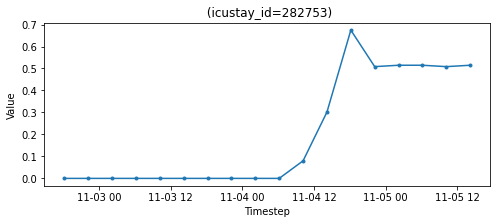

In [14]:
# Example vasopressor trajectory from MV
plot_single(sampled_vaso_mv_df, item_id='max_vaso')

In [15]:
# How many admissions were recorded in MetaVision?
vaso_mv_episodes = sampled_vaso_mv_df['episode'].unique()
print('MetaVision max_vaso records: %s' % len(vaso_mv_episodes))

MetaVision max_vaso records: 4131


### 2. CareVue Records (Optional)

In [17]:
if USE_CAREVUE:
    # Load converted CV data
    vaso_cv_df = read_csv(DATA_DIR + 'vassopressors_cv_cohort_v2.csv')

    # Process admissions one-by-one
    sampled_vaso_cv_dfs = []
    for icustay_id, treatments in tqdm(vaso_cv_df.groupby('icustay_id')):

        # Part of sepsis-3 cohort?
        if icustay_id not in interval_times:
            continue
            
        # Skip admission if already in MV
        if icustay_id in vaso_mv_episodes:
            continue

        # Empty vector to store max_vaso values into
        intervals = interval_times[icustay_id]
        max_vaso = np.zeros(len(intervals), dtype=np.float64)

        for i, (interval_start, interval_end) in enumerate(intervals):        
            # Inclusion test: treatment timeframe overlaps with current interval.
            condition = (treatments['starttime'] <= interval_end) & (treatments['endtime'] > interval_start)
            max_vaso[i] = treatments[condition]['mcgkgmin'].max() # Why max?

        # Create DataFrame for ICU stay
        sampled_vaso_cv_df = pd.DataFrame({'timestep': [start for start, _ in intervals],
                                           'episode': icustay_id,
                                           'x0': 'max_vaso',
                                           'x1': np.nan_to_num(max_vaso, nan=0.0)}) # NaN (no treatment) -> zero dose
        sampled_vaso_cv_dfs.append(sampled_vaso_cv_df)

    # Concat DataFrames of individual icustays
    sampled_vaso_cv_df = pd.concat(sampled_vaso_cv_dfs)
    
    del vaso_cv_df, sampled_vaso_cv_dfs

100%|██████████████████████████████████████████████████████████████████████████████| 3898/3898 [00:53<00:00, 72.46it/s]


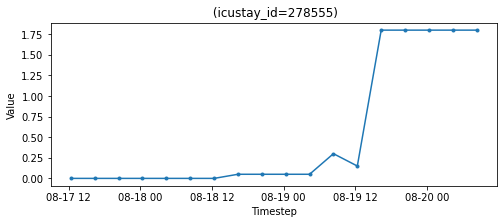

In [25]:
# Plot example vasopressor trajectory from CareVue
if USE_CAREVUE:
    plot_single(sampled_vaso_cv_df, item_id='max_vaso')

In [19]:
# How many admissions were recorded in CareVue?
if USE_CAREVUE:
    vaso_cv_episodes = sampled_vaso_cv_df['episode'].unique()
    print('CareVue max_vaso records: %s' % len(vaso_cv_episodes))

CareVue max_vaso records: 3875


### Combine CareVue Records with MetaVision (Optional)

In [26]:
# Merge CV and MV records if processed; otherwise just use MV
if USE_CAREVUE:
    sampled_vaso_df = pd.concat([sampled_vaso_mv_df, sampled_vaso_cv_df])
else:
    sampled_vaso_df = sampled_vaso_mv_df

In [27]:
num_admissions = len(sampled_vaso_df['episode'].unique())
print('Total admissions:', num_admissions)

Total admissions: 8006


---
## IV Fluids

### 1. MetaVision Records

In [28]:
iv_fluid_mv_df = read_csv(DATA_DIR + 'inputevents_mv_cohort.csv')

# Drop 14-Oral/Gastric Intake (i.e. having a glass of water)
condition = (iv_fluid_mv_df['ordercategoryname'] != '14-Oral/Gastric Intake') & (iv_fluid_mv_df['amountuom'] == 'ml')
iv_fluid_mv_df = iv_fluid_mv_df.loc[condition]

# Sanity check: remove amounts outside (0, 5000) range
iv_fluid_mv_df = iv_fluid_mv_df.loc[(iv_fluid_mv_df['amount'] > 0) & (iv_fluid_mv_df['amount'] < 5000)]

# Compute duration in hours
# NOTE: original erroneously measured time in minutes
iv_fluid_mv_df['duration'] = (iv_fluid_mv_df['endtime'] - iv_fluid_mv_df['starttime']).astype('timedelta64[s]').astype(int) / 3600

# Drop many useless columns
iv_fluid_mv_df = iv_fluid_mv_df[['subject_id', 'hadm_id', 'icustay_id', 'starttime', 'endtime', 'amount', 'duration']]
iv_fluid_mv_df.head()

,subject_id,hadm_id,icustay_id,starttime,endtime,amount,duration
2,23,124321,234044.0,2157-10-21 15:00:00,2157-10-21 15:01:00,200.000000,0.016667
4,23,124321,234044.0,2157-10-21 12:15:00,2157-10-21 13:22:00,13.432238,1.116667
7,23,124321,234044.0,2157-10-21 17:08:00,2157-10-21 18:08:00,49.999999,1.000000
10,23,124321,234044.0,2157-10-22 08:00:00,2157-10-22 08:01:00,200.000000,0.016667
14,23,124321,234044.0,2157-10-22 09:24:00,2157-10-22 09:48:00,1.602968,0.400000


**Computing IV fluid intake:**<br>
In order to determine the total amount of IV fluid administered within a 4 hour interval, we need to calculate how long a treatment was administered for during an interval; multiplied by the rate (i.e. `amount / duration`) we can infer the total amount administered by each treatment during the current interval. For this we use the `total_admin_in_interval` function below:

In [29]:
# Computes how much of each dose was administered between interval_start and interval_end
def total_admin_in_interval(interval_start, interval_end, treatments):
    dose_start = treatments['starttime']
    dose_end = treatments['endtime']
    amount = treatments['amount']
    duration = treatments['duration']
    rate = amount / duration # in ml/hour!   
    
    total_ml = 0
    
    # Option 1: Dose started before interval and ended after interval
    c1 = (dose_start < interval_start) & (dose_end > interval_end)
    if c1.any():
        total_ml += (to_hours(interval_end - interval_start) * rate[c1]).sum()
    
    # Option 2: Dose started before and ended within interval
    c2 = (dose_start < interval_start) & (dose_end > interval_start) & (dose_end <= interval_end)
    if c2.any():
        total_ml += (to_hours(dose_end - interval_start) * rate[c2]).sum()

    # Option 3: Dose started and ended in interval
    c3 = (dose_start >= interval_start) & (dose_start < interval_end) & (dose_end <= interval_end) & (dose_end > interval_start)
    if c3.any():
        total_ml += amount[c3].sum()
    
    # Option 4: dose started in interval and ended after interval
    c4 = (dose_start >= interval_start) & (dose_start < interval_end) & (dose_end > interval_end)
    if c4.any():
        total_ml += (to_hours(interval_end - dose_start) * rate[c4]).sum()
            
    return total_ml

We can now use `total_admin_in_interval()` on each interval `(interval_start, interval_end)` and treatments in `ivfluid_mv_df` to compute the total IV fluid administration within each 4 hour interval:

In [30]:
sampled_iv_fluid_mv_dfs = []

# Process admissions one-by-one
for icustay_id, treatments in tqdm(iv_fluid_mv_df.groupby('icustay_id'), desc='Give me a bit'):
    
    # Is icustay part of cohort?
    if icustay_id not in interval_times:
        continue
    
    intervals = interval_times[icustay_id]
    total_iv_fluid = np.zeros(len(intervals), dtype=np.float64)
    
    # Compute total IV fluid within each interval
    for i, (interval_start, interval_end) in enumerate(intervals):
        total_iv_fluid[i] = total_admin_in_interval(interval_start, interval_end, treatments)
                
    # Convert to DataFrame
    sampled_iv_fluid_df = pd.DataFrame({'episode': icustay_id,
                                        'timestep': [start for start, _ in intervals],
                                        'x0': 'total_iv_fluid',
                                        'x1': total_iv_fluid})
    sampled_iv_fluid_mv_dfs.append(sampled_iv_fluid_df)
    
# Concat DataFrames of individual icustays
sampled_iv_fluid_mv_df = pd.concat(sampled_iv_fluid_mv_dfs)
sampled_iv_fluid_mv_df.tail()

Give me a bit: 100%|█████████████████████████████████████████████████████████████| 13593/13593 [09:01<00:00, 25.09it/s]


,episode,timestep,x0,x1
13,299998.0,2181-07-06 13:12:00,total_iv_fluid,1200.00000
14,299998.0,2181-07-06 17:12:00,total_iv_fluid,1200.00000
15,299998.0,2181-07-06 21:12:00,total_iv_fluid,1324.22749
16,299998.0,2181-07-07 01:12:00,total_iv_fluid,1183.94160
17,299998.0,2181-07-07 05:12:00,total_iv_fluid,2194.33090


In [31]:
del iv_fluid_mv_df, sampled_iv_fluid_mv_dfs

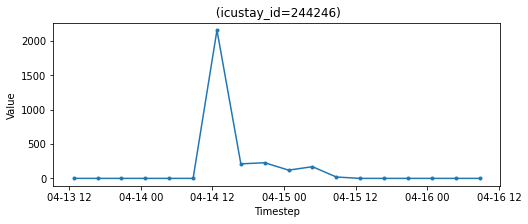

In [34]:
# Get total IV fluid intake for one random patient
plot_single(sampled_iv_fluid_mv_df, item_id='total_iv_fluid')

In [33]:
# How many admissions were recorded in MetaVision?
iv_fluid_mv_episodes = sampled_iv_fluid_mv_df['episode'].unique()
print('MetaVision total_iv_fluid records: %s' % len(iv_fluid_mv_episodes))

MetaVision total_iv_fluid records: 9203


### 2. CareVue Records (Optional)

In [36]:
if USE_CAREVUE:
    # Load data
    iv_fluid_cv_df = read_csv(DATA_DIR + 'inputevents_cv_cohort_v2.csv')

    # Sanity check: remove amounts outside (0, 5000) range
    iv_fluid_cv_df = iv_fluid_cv_df.loc[(iv_fluid_cv_df['amount'] > 0) & (iv_fluid_cv_df['amount'] < 5000)]

    # Compute duration in hours
    iv_fluid_cv_df['duration'] = iv_fluid_cv_df['endtime'] - iv_fluid_cv_df['starttime']).astype('timedelta64[s]').astype(int) / 3600

    # Process admissions one-by-one
    sampled_iv_fluid_cv_dfs = []
    for icustay_id, treatments in tqdm(iv_fluid_cv_df.groupby('icustay_id'), desc='Grab another coffee!'):
    
        # Is icustay part of cohort?
        if icustay_id not in interval_times:
            continue
            
        # Skip if already recorded by MV
        if icustay_id in iv_fluid_mv_episodes:
            continue

        intervals = interval_times[icustay_id]
        total_iv_fluid = np.zeros(len(intervals), dtype=np.float64)

        # Compute total IV fluid within each interval
        for i, (interval_start, interval_end) in enumerate(intervals):
            total_iv_fluid[i] = total_admin_in_interval(interval_start, interval_end, treatments)

        # Convert to DataFrame
        sampled_iv_fluid_df = pd.DataFrame({'episode': icustay_id,
                                            'timestep': [start for start, _ in intervals],
                                            'x0': 'total_iv_fluid',
                                            'x1': total_iv_fluid})
        sampled_iv_fluid_cv_dfs.append(sampled_iv_fluid_df)

    # Concat DataFrames of individual admissions
    sampled_iv_fluid_cv_df = pd.concat(sampled_iv_fluid_cv_dfs)
    
    del iv_fluid_cv_df

Grab another coffee!: 100%|████████████████████████████████████████████████████████| 8919/8919 [08:54<00:00, 16.69it/s]


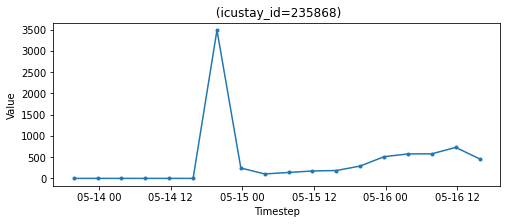

In [37]:
# Get total IV fluid intake for one random patient
if USE_CAREVUE:
    plot_single(sampled_iv_fluid_cv_df, item_id='total_iv_fluid')

In [38]:
# How many admissions were recorded in CareVue?
if USE_CAREVUE:
    iv_fluid_cv_episodes = sampled_iv_fluid_cv_df['episode'].unique()
    print('CareVue total_iv_fluid records: %s' % len(iv_fluid_cv_episodes))

CareVue total_iv_fluid records: 8768


#### Combine CareVue Fluid Records with MetaVision

In [41]:
# Merge CV and MV records if processed; otherwise just use MV
if USE_CAREVUE:
    sampled_iv_fluid_df = pd.concat([sampled_iv_fluid_mv_df, sampled_iv_fluid_cv_df])
else:
    sampled_iv_fluid_df = sampled_iv_fluid_mv_df

In [42]:
num_admissions = len(sampled_iv_fluid_df['episode'].unique())
print('Total admissions:', num_admissions)

Total admissions: 17971


---
## Vitals

Vitals are already in the correct format, therefore we only need to rename the columns, drop unnecessary ones and snake-case the `vital_ids`;

In [43]:
vitals_df = read_csv(DATA_DIR + 'vitals_cohort.csv')

# Simply rename columns (vitals_df is already in the right format)
vitals_df = pd.DataFrame({'episode': vitals_df['icustay_id'],
                          'timestep': vitals_df['charttime'],
                          'x0': vitals_df['vital_id'].apply(to_snakecase),
                          'x1': vitals_df['valuenum']})
vitals_df.head()

,episode,timestep,x0,x1
0,294638,2191-03-16 01:30:00,heart_rate,111.000000
1,294638,2191-03-16 01:30:00,sp_o2,98.000000
2,294638,2191-03-16 01:30:00,temp_c,37.444445
3,294638,2191-03-16 02:00:00,dias_bp,63.000000
4,294638,2191-03-16 02:00:00,heart_rate,100.000000


---
## Lab Results

In [44]:
lab_df = read_csv(DATA_DIR + 'labs_cohort.csv')

# Drop NaNs in lab_id column
lab_df = lab_df[lab_df['lab_id'].notna()]

# Simply rename columns (lab_df is already in the right format)
lab_df = pd.DataFrame({'episode': lab_df['icustay_id'],
                       'timestep': lab_df['charttime'],
                       'x0': lab_df['lab_id'].apply(to_snakecase),
                       'x1': lab_df['valuenum']})
lab_df.head()

,episode,timestep,x0,x1
0,294638,2191-03-15 14:12:00,alat,28.0
1,294638,2191-03-15 14:12:00,anion gap,17.0
2,294638,2191-03-15 14:12:00,asat,69.0
3,294638,2191-03-15 14:12:00,bicarbonate,24.0
4,294638,2191-03-15 14:12:00,bilirubin,2.2


---
## FiO2 (Fraction of Inspired Oxygen)

In [45]:
fio2_df = read_csv(DATA_DIR + 'fio2_cohort.csv')

fio2_df = pd.DataFrame({'episode': fio2_df['icustay_id'],
                        'timestep': fio2_df['charttime'],
                        'x0': 'fi_o2',
                        'x1': fio2_df['fio2']})
fio2_df.head()

,episode,timestep,x0,x1
0,294638,2191-03-16 03:00:00,fi_o2,94.999999
1,294638,2191-03-16 08:00:00,fi_o2,50.000000
2,294638,2191-03-16 11:00:00,fi_o2,NaN
3,220597,2149-11-09 13:40:00,fi_o2,NaN
4,220597,2149-11-09 17:00:00,fi_o2,60.000002


---
## Urine Output

In [46]:
urineoutput_df = read_csv(DATA_DIR + 'urineoutput_cohort.csv')

urineoutput_df = pd.DataFrame({'episode': urineoutput_df['icustay_id'],
                               'timestep': urineoutput_df['charttime'],
                               'x0': 'urine_output',
                               'x1': urineoutput_df['value']})
urineoutput_df.head()

,episode,timestep,x0,x1
0,205353,2140-12-01 02:00:00,urine_output,5.0
1,210804,2132-06-03 08:00:00,urine_output,100.0
2,236794,2100-11-01 01:00:00,urine_output,150.0
3,247650,2141-08-23 18:00:00,urine_output,160.0
4,233215,2167-07-28 07:00:00,urine_output,45.0


---
## Demographics

We repeat demographics at every decision point as we may need to truncate the sequence when it gets too long; then demographic information stored at the beginning of the sequence may be lost (e.g. as they were measured on admission)...

In [47]:
USED_DEMOGRAPHICS = ['age', 'height', 'is_male', 'weight', 'vent', 'sofa', 'sirs']

In [48]:
demo_df = read_csv(DATA_DIR + 'demographics_cohort.csv')[['icustay_id'] + USED_DEMOGRAPHICS]

# Merge table to be able to access window_start
demo_df = demo_df.merge(cohort_df[['icustay_id', 'window_start']], on='icustay_id', how='inner')
demo_df.head()

,icustay_id,age,height,is_male,weight,vent,sofa,sirs,window_start
0,200003,48.2940,177.80,1,77.0,1,6,4,2199-08-01 21:02:00
1,200014,84.7274,167.64,1,62.0,1,3,4,2105-02-16 00:00:00
2,200019,82.8820,NaN,0,65.0,1,5,3,2178-07-07 21:51:00
3,200030,54.1915,187.96,1,113.6,0,7,4,2150-11-12 00:00:00
4,200035,30.6591,NaN,1,95.5,0,2,3,2156-10-06 16:50:00


In [49]:
minute = pd.to_timedelta('1m')

# Create df with demographics as measurements
demo_dfs = []
for icustay_id, icustay_demo_df in tqdm(demo_df.groupby('icustay_id')):
    
    # Repeat demographics at every decision point! 
    for feat in USED_DEMOGRAPHICS:
        demo_df2 = pd.DataFrame({'episode': icustay_id,
                                 'timestep': [start - minute for start, _ in interval_times[icustay_id]], # one minute before actual decision point!
                                 'x0': feat,
                                 'x1': icustay_demo_df[feat].values[0]})
        demo_dfs.append(demo_df2)
    
demo_df = pd.concat(demo_dfs)
demo_df.head()

100%|███████████████████████████████████████████████████████████████████████████| 18091/18091 [02:11<00:00, 137.65it/s]


,episode,timestep,x0,x1
0,200003,2199-08-01 21:01:00,age,48.294
1,200003,2199-08-02 01:01:00,age,48.294
2,200003,2199-08-02 05:01:00,age,48.294
3,200003,2199-08-02 09:01:00,age,48.294
4,200003,2199-08-02 13:01:00,age,48.294


In [50]:
del demo_dfs

---
## Putting It All Together

In [68]:
# Merge measurement DataFrames
full_df = pd.concat([sampled_vaso_df,
                     demo_df,
                     sampled_iv_fluid_df, 
                     vitals_df, 
                     lab_df, 
                     fio2_df, 
                     urineoutput_df]).dropna(axis=0).reset_index(drop=True)

# Group by admissions and timestep
full_df = full_df.sort_values(by=['episode', 'timestep']).reset_index(drop=True)

In [69]:
shuffled_full_df = full_df.sample(frac=1)
shuffled_full_df.head()

,timestep,episode,x0,x1
8360068,2134-07-19 18:45:00,283762.0,sys_bp,150.0
125618,2151-10-19 08:00:00,201358.0,mean_bp,93.0
8574034,2167-03-26 20:00:00,285887.0,bun,17.0
469901,2117-12-19 14:03:00,205032.0,urine_output,100.0
4936731,2131-05-29 02:00:00,250001.0,dias_bp,36.0


In [70]:
del shuffled_full_df

In [71]:
num_admissions = len(full_df['episode'].unique())
print('Total admissions:', num_admissions)

Total admissions: 18331


---
## Add Discretized Action Space and Rewards

In [72]:
# Load previously-estimated action-space bins
max_vaso_bins = np.loadtxt(OUTPUT_DIR_ROGGEVEEN + '/max_vaso_bins.npy')
print('Max vasopressor bins:')
print(max_vaso_bins.round(3), '\n')

total_iv_fluid_bins = np.loadtxt(OUTPUT_DIR_ROGGEVEEN + '/total_iv_fluid_bins.npy')
print('IV fluid bins:')
print(total_iv_fluid_bins.round(3))

Max vasopressor bins:
[ -inf 0.    0.09  0.225 0.45    inf] 

IV fluid bins:
[   -inf   0.    200.    463.735 907.743     inf]


In [73]:
def actions_and_rewards(max_vaso_df, iv_fluid_df, max_vaso_bins, iv_fluid_bins, cohort_df):    
    # Merge vasopressor and IV fluid DataFrames
    action_space_df = pd.concat([max_vaso_df, iv_fluid_df])

    action_reward_dfs = []
    for icustay_id, icustay_data in tqdm(action_space_df.groupby('episode')):
        
        # Get VP and IV records over time
        max_vaso = icustay_data[icustay_data['x0'] == 'max_vaso'].sort_values('timestep')
        iv_fluid = icustay_data[icustay_data['x0'] == 'total_iv_fluid'].sort_values('timestep')
        
        # If no vasopressors or IV fluids were recorded, assume zeros (no treatment)
        timesteps = [start for start, _ in interval_times[icustay_id]]
        max_vaso = max_vaso['x1'].values if len(max_vaso) > 0 else np.zeros(len(timesteps))
        iv_fluid = iv_fluid['x1'].values if len(iv_fluid) > 0 else np.zeros(len(timesteps))

        # Discretize to 5x5 action space using precomputed bins
        max_vaso_discrete = pd.cut(x=max_vaso, 
                                   bins=max_vaso_bins, 
                                   labels=[0, 1, 2, 3, 4], 
                                   include_lowest=True).astype(float)

        iv_fluid_discrete = pd.cut(x=iv_fluid, 
                                   bins=iv_fluid_bins, 
                                   labels=[0, 1, 2, 3, 4], 
                                   include_lowest=True).astype(float)

        actions = 5 * iv_fluid_discrete + max_vaso_discrete
        
        # Determine rewards based on hospital_expire_flag in cohort.csv
        deceased = cohort_df[cohort_df['icustay_id'] == icustay_id]['hospital_expire_flag'].values[0]
        rewards = np.zeros(len(timesteps))
        rewards[-1] = 15 if not deceased else -15

        # Merge into DataFrame
        action_df = pd.DataFrame({'timestep': timesteps,
                                  'episode': icustay_id,
                                  'x0': 'action',
                                  'x1': 0,  # -> Nothing is measured
                                  'action': actions,
                                  'reward': rewards})
        action_reward_dfs.append(action_df)

    # Concat DataFrames of individual icustays
    action_reward_df = pd.concat(action_reward_dfs).reset_index(drop=True)
    return action_reward_df

In [74]:
action_reward_df = actions_and_rewards(sampled_vaso_df, sampled_iv_fluid_df, max_vaso_bins, total_iv_fluid_bins, cohort_df)

print('num decision times: %s\n' % len(action_reward_df))
action_reward_df.head(18) # Check: Should see some non-zero rewards

100%|███████████████████████████████████████████████████████████████████████████| 17972/17972 [01:18<00:00, 230.07it/s]


num decision times: 323496



,timestep,episode,x0,x1,action,reward
0,2199-08-01 21:02:00,200003.0,action,0,0.0,0.0
1,2199-08-02 01:02:00,200003.0,action,0,0.0,0.0
2,2199-08-02 05:02:00,200003.0,action,0,0.0,0.0
3,2199-08-02 09:02:00,200003.0,action,0,0.0,0.0
4,2199-08-02 13:02:00,200003.0,action,0,0.0,0.0
5,2199-08-02 17:02:00,200003.0,action,0,20.0,0.0
6,2199-08-02 21:02:00,200003.0,action,0,20.0,0.0
7,2199-08-03 01:02:00,200003.0,action,0,15.0,0.0
8,2199-08-03 05:02:00,200003.0,action,0,20.0,0.0
9,2199-08-03 09:02:00,200003.0,action,0,10.0,0.0


In [75]:
# Add (action, reward) pairs to full_df as new rows
full_df = pd.concat([full_df, action_reward_df])

# Sort to fix ordering
full_df = full_df.sort_values(by=['episode', 'timestep']).reset_index(drop=True)
full_df.head()

,timestep,episode,x0,x1,action,reward
0,2199-08-01 21:01:00,200003.0,age,48.294,NaN,NaN
1,2199-08-01 21:01:00,200003.0,height,177.800,NaN,NaN
2,2199-08-01 21:01:00,200003.0,is_male,1.000,NaN,NaN
3,2199-08-01 21:01:00,200003.0,weight,77.000,NaN,NaN
4,2199-08-01 21:01:00,200003.0,vent,1.000,NaN,NaN


---

## Drop Impossible Actions

Actions 1 - 4 are not possible as they prescribe VP without IV injection. This is not possible as VP are administered through IV. We will drop any actions of this kind (if there are any) to action 0 (no drug).

In [76]:
full_df.loc[(full_df['x0'] == 'action') & full_df['x1'].isin([1, 2, 3, 4]), 'x1'] = 0

In [77]:
assert full_df[full_df['x0'] == 'action']['x1'].isin([1, 2, 3, 4]).sum() == 0

---
## Move Vasopressor and IV Fluid by `INTERVAL_TIME` (so model cannot peak at it current value!)

In [78]:
# Vasopressor
full_df.loc[full_df['x0'] == 'max_vaso', 'timestep'] += pd.to_timedelta(INTERVAL_TIME)

# IV fluids
full_df.loc[full_df['x0'] == 'total_iv_fluid', 'timestep'] += pd.to_timedelta(INTERVAL_TIME)

---
## Map Strings of `x0` to Integer IDs
The `x0` feature (storing string ids such as `heart_rate` and `respiratory_rate`) uses strings. To let our transformer model use these IDs for indexing of embeddings, we convert these strings to integer IDs.

In [79]:
measurements = list(full_df['x0'].unique())

# Ensure 'action' is last ID in x0!
measurements.remove('action')
measurements.append('action')
measurements = np.array(measurements)

measurements

array(['age', 'height', 'is_male', 'weight', 'vent', 'sofa', 'sirs',
       'max_vaso', 'total_iv_fluid', 'alat', 'albumin', 'anion gap',
       'asat', 'bands', 'bicarbonate', 'bilirubin', 'bun', 'calcium',
       'chloride', 'creatinine', 'glucose', 'hemoglobin', 'magnesium',
       'platelet', 'potassium', 'pt', 'ptt', 'sodium', 'wbc', 'dias_bp',
       'heart_rate', 'mean_bp', 'resp_rate', 'sp_o2', 'sys_bp',
       'urine_output', 'temp_c', 'base_excess', 'ion_calcium', 'lactate',
       'paco2', 'pao2', 'ph', 'fi_o2', 'action'], dtype='<U14')

In [80]:
# Create dict to map from string IDs to integer IDs (starting at 1)
mapping = {m:i + 1 for i, m in enumerate(measurements)}

# Convert `x0` to integer IDs
full_df['x0'] = full_df['x0'].replace(mapping)
full_df.head()
print('Done!')

Done!


In [81]:
# Save mapping as file for later reference
with open(OUTPUT_DIR + 'measurement_ids.txt', 'w') as file:
    file.write('\n'.join(measurements))

---
## Exclude No-Treatment Admissions
There are some admissions in which no hemodynamic treatments are prescribed; we will filter out these treatments as done in Roggeveen et al.;

In [82]:
# Identify admissions where treatments were registered (at least one action > 0)
admission_has_treatment = full_df.groupby('episode', sort=False)['action'].agg(np.max) > 0
icustay_ids = admission_has_treatment.index[admission_has_treatment.values]

# Drop all non-treatment admissions
full_df = full_df[full_df['episode'].isin(icustay_ids)]

In [83]:
print('Number of admissions after filtering:', len(icustay_ids))

Number of admissions after filtering: 15084


---
## Train/Valid/Test Split
We will use the dataset split created in `MIMIC-III_preprocessing_roggeveen.ipynb` to allow a fair comparison between models;

In [84]:
train_icustay_ids = np.loadtxt(OUTPUT_DIR_ROGGEVEEN + '/mimic-iii_icustay_ids_train.npy')
valid_icustay_ids = np.loadtxt(OUTPUT_DIR_ROGGEVEEN + '/mimic-iii_icustay_ids_valid.npy')
test_icustay_ids = np.loadtxt(OUTPUT_DIR_ROGGEVEEN + '/mimic-iii_icustay_ids_test.npy')

# Timestamped measurements, e.g. vitals, lab results, vasopressor/IV-fluid doses, etc.
train_df = full_df[full_df['episode'].isin(train_icustay_ids)].copy() # to prevent warnings
valid_df = full_df[full_df['episode'].isin(valid_icustay_ids)].copy()
test_df = full_df[full_df['episode'].isin(test_icustay_ids)].copy()

assert set(train_df.episode.unique()) == set(train_icustay_ids)
assert set(valid_df.episode.unique()) == set(valid_icustay_ids)
assert set(test_df.episode.unique()) == set(test_icustay_ids)
print('Done!')

Done!


---
## Feature scaling: zero mean 'n unit variance

In [85]:
# Compute averages and stdevs over measurements in training set with same item_id (e.g. 'heart_rate')
item_avg = train_df.groupby('x0')['x1'].mean().to_dict()
item_std = train_df.groupby('x0')['x1'].std().to_dict()

# Prevents action (x0=43) from being scaled (causing divide by zero)
item_avg[mapping['action']] = 0
item_std[mapping['action']] = 1

In [86]:
def scale_features_by_item(values):
    item_id = values.name
    return (values - item_avg[item_id]) / item_std[item_id]

# Scale measurements
train_df['x1'] = train_df.groupby('x0')['x1'].transform(scale_features_by_item)
valid_df['x1'] = valid_df.groupby('x0')['x1'].transform(scale_features_by_item)
test_df['x1'] = test_df.groupby('x0')['x1'].transform(scale_features_by_item)
print('Done!')

Done!


#### Sanity check

In [87]:
# Note: `action` should have std. = 0, everything else std. = 1 with zero mean
pd.DataFrame({'avg.': train_df.groupby('x0')['x1'].mean().round(3), 
              'std.': train_df.groupby('x0')['x1'].std().round(3)}).T

x0,1,2,3,4,5,6,7,8,9,10,...,36,37,38,39,40,41,42,43,44,45
avg.,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,...,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0
std.,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


---
## Add Timestep as Feature (in hours from `window_start`)

In [88]:
def timestep_to_hours(dataset):
    return dataset.groupby('episode')['timestep'].transform(lambda x: to_hours(x - x.min())) 

# Add timestep (starting at 0 hours) as additional feature
train_df['x2'] = timestep_to_hours(train_df)
valid_df['x2'] = timestep_to_hours(valid_df)
test_df['x2'] = timestep_to_hours(test_df)

valid_df.head(10)

,timestep,episode,x0,x1,action,reward,x2
26146,2137-11-14 20:39:00,200227.0,1,0.525400,NaN,NaN,0.000000
26147,2137-11-14 20:39:00,200227.0,2,-0.130913,NaN,NaN,0.000000
26148,2137-11-14 20:39:00,200227.0,3,0.865712,NaN,NaN,0.000000
26149,2137-11-14 20:39:00,200227.0,4,-0.259605,NaN,NaN,0.000000
26150,2137-11-14 20:39:00,200227.0,5,-1.152658,NaN,NaN,0.000000
26151,2137-11-14 20:39:00,200227.0,6,-0.148412,NaN,NaN,0.000000
26152,2137-11-14 20:39:00,200227.0,7,1.119555,NaN,NaN,0.000000
26153,2137-11-15 00:40:00,200227.0,9,-0.494538,NaN,NaN,4.016667
26154,2137-11-14 20:40:00,200227.0,45,0.000000,0.0,0.0,0.016667
26155,2137-11-15 00:39:00,200227.0,1,0.525400,NaN,NaN,4.000000


### Sort and Export Datasets

In [89]:
# Sort within episode in order of time (also on x0 to make 'action' last at timestep)
train_df = train_df.sort_values(by=['episode', 'timestep', 'x0'])
valid_df = valid_df.sort_values(by=['episode', 'timestep', 'x0'])
test_df = test_df.sort_values(by=['episode', 'timestep', 'x0'])

# Save training, validation and test sets
train_df.to_csv(OUTPUT_DIR + 'mimic-iii_train.csv', index=False)
valid_df.to_csv(OUTPUT_DIR + 'mimic-iii_valid.csv', index=False)
test_df.to_csv(OUTPUT_DIR + 'mimic-iii_test.csv', index=False)
print('Done!')

Done!


---
## Let's Visualize!

Messy as expected...

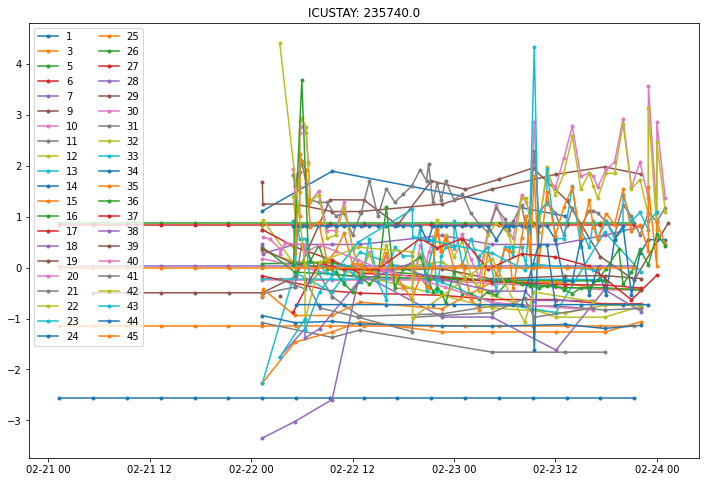

In [104]:
# Sample measurements for one admission by icustay_id
icustay_id = random.choice(train_df['episode'].values)
icustay_df = train_df[train_df['episode'] == icustay_id]

plt.figure(figsize=(12, 8))

for item_id, item_df in icustay_df.groupby('x0'):
    plt.plot(item_df['timestep'], item_df['x1'], '.-', label=item_id)
    
plt.title('ICUSTAY: %s' % icustay_id)
plt.legend(ncol=2)
plt.show()

Note the straight lines which are sampled regularly over time; these represent demographics (e.g. `age` or `weight`). Also, notice that some variables may be missing at times (particularly at the edges of the figure); As we use a transformer there is no need to impute these values: afterall, the physician does not have access to these unknwon measurements either...